# Enable Agent Tutorial Part 3: Detection Context Builder

## 개요

플라스틱 탐지 결과를 저장하고 지식 베이스로 변환한다.

In [1]:
import json
import yaml
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List
from collections import defaultdict
import matplotlib.pyplot as plt
from ultralytics import YOLO
from dotenv import load_dotenv
load_dotenv()
print("라이브러리 임포트 완료")

라이브러리 임포트 완료


In [2]:
class DetectionContextBuilder:
    def __init__(self, context_dir: str = 'context_store'):
        self.context_dir = Path(context_dir)
        self.context_dir.mkdir(exist_ok=True)
        self.log_file = self.context_dir / 'detection_logs.json'
        self.summary_file = self.context_dir / 'detection_summary.json'
        self.knowledge_base_file = self.context_dir / 'detection_knowledge_base.txt'
        self.logs = self._load_logs()
        print(f"Context Builder 초기화 완료 (로그: {len(self.logs)}개)")
    
    def _load_logs(self):
        if self.log_file.exists():
            with open(self.log_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return []
    
    def add_detection(self, result: Dict, image_path: str = None):
        log_entry = {
            'detection_id': len(self.logs) + 1,
            'result': result,
            'image_path': image_path,
            'logged_at': datetime.now().isoformat()
        }
        self.logs.append(log_entry)
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.logs, f, indent=2, ensure_ascii=False)
        self._update_summary()
        self._update_knowledge_base()
        print(f"탐지 결과 저장 완료 (총 {len(self.logs)}개)")
    
    def _update_summary(self):
        if not self.logs: return
        total = len(self.logs)
        total_det = sum(l['result']['num_detections'] for l in self.logs)
        class_stats = defaultdict(lambda: {'count': 0, 'confidences': []})
        for log in self.logs:
            for det in log['result']['detections']:
                class_stats[det['class_name']]['count'] += 1
                class_stats[det['class_name']]['confidences'].append(det['confidence'])
        for cls, stats in class_stats.items():
            stats['avg_confidence'] = sum(stats['confidences']) / len(stats['confidences'])
            del stats['confidences']
        summary = {'total_images': total, 'total_detections': total_det,
                   'class_statistics': dict(class_stats), 'last_updated': datetime.now().isoformat()}
        with open(self.summary_file, 'w', encoding='utf-8') as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)
    
    def _update_knowledge_base(self):
        if not self.logs: return
        summary = self.get_summary()
        kb = f"""# 플라스틱 탐지 지식 베이스\n\n총 이미지: {summary['total_images']}장\n총 탐지: {summary['total_detections']}개\n"""
        for cls, stats in summary.get('class_statistics', {}).items():
            kb += f"\n{cls.upper()}: {stats['count']}개 (평균 신뢰도 {stats['avg_confidence']:.1%})"
        with open(self.knowledge_base_file, 'w', encoding='utf-8') as f:
            f.write(kb)
    
    def get_summary(self):
        if self.summary_file.exists():
            with open(self.summary_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return {}
    
    def get_knowledge_base_content(self):
        if self.knowledge_base_file.exists():
            with open(self.knowledge_base_file, 'r', encoding='utf-8') as f:
                return f.read()
        return ""
    
    def clear_logs(self):
        self.logs = []
        for f in [self.log_file, self.summary_file, self.knowledge_base_file]:
            if f.exists(): f.unlink()
        print("로그 초기화 완료")

print("DetectionContextBuilder 정의 완료")

DetectionContextBuilder 정의 완료


In [3]:
class PlasticDetectionAgent:
    def __init__(self, skill_path: str):
        with open(skill_path, 'r', encoding='utf-8') as f:
            self.skill = yaml.safe_load(f)
        model_path = self.skill['model_info']['model_path']
        self.model = YOLO(model_path) if Path(model_path).exists() else YOLO('yolov8n.pt')
        self.classes = self.skill['classes']
        print("PlasticDetectionAgent 초기화 완료")
    
    def detect(self, image_path: str, confidence_threshold: float = 0.25):
        results = self.model.predict(source=image_path, conf=confidence_threshold, verbose=False)
        detections = []
        for result in results:
            for box in result.boxes:
                cls_id = int(box.cls[0])
                if cls_id in self.classes:
                    info = self.classes[cls_id]
                    detections.append({
                        'class_id': cls_id, 'class_name': info['name'],
                        'confidence': float(box.conf[0]), 'bbox': box.xyxy[0].tolist(),
                        'recycle_code': info['recycle_code']
                    })
        return {'detections': detections, 'num_detections': len(detections),
                'timestamp': datetime.now().isoformat()}

print("PlasticDetectionAgent 정의 완료")

PlasticDetectionAgent 정의 완료


In [4]:
agent = PlasticDetectionAgent('skills/yolo_agent_skill.yaml')
context_builder = DetectionContextBuilder()

PlasticDetectionAgent 초기화 완료
Context Builder 초기화 완료 (로그: 0개)


In [5]:
# 테스트 탐지 및 저장
test_images = list(Path('datasets/plastic/val/images').glob('*.jpg'))
if test_images:
    for img_path in test_images[:3]:
        result = agent.detect(str(img_path))
        context_builder.add_detection(result, str(img_path))
        print(f"  {img_path.name}: {result['num_detections']}개 탐지")

탐지 결과 저장 완료 (총 1개)
  plastic_test_021.jpg: 3개 탐지
탐지 결과 저장 완료 (총 2개)
  plastic_test_006.jpg: 6개 탐지
탐지 결과 저장 완료 (총 3개)
  plastic_test_010.jpg: 5개 탐지


In [6]:
print("=== 지식 베이스 ===")
print(context_builder.get_knowledge_base_content())

=== 지식 베이스 ===
# 플라스틱 탐지 지식 베이스

총 이미지: 3장
총 탐지: 14개

PET: 5개 (평균 신뢰도 81.1%)
PS: 3개 (평균 신뢰도 56.7%)
PP: 5개 (평균 신뢰도 66.4%)
PE: 1개 (평균 신뢰도 51.4%)


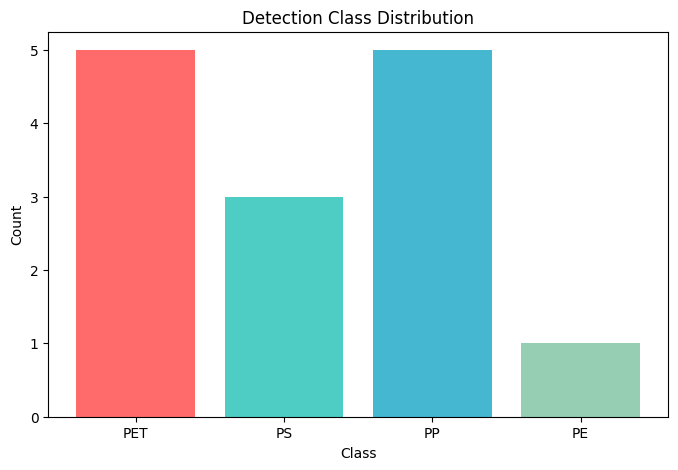

In [7]:
summary = context_builder.get_summary()
if summary.get('class_statistics'):
    classes = list(summary['class_statistics'].keys())
    counts = [summary['class_statistics'][c]['count'] for c in classes]
    plt.figure(figsize=(8, 5))
    plt.bar([c.upper() for c in classes], counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(classes)])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Detection Class Distribution')
    plt.show()